## Import Statements

In [1]:
import os
import sys

from random import shuffle

import numpy as np

import pandas as pd

import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, models, transforms
import torch.optim as optim
import torch.nn as nn

from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Read in Data

In [2]:
data_path = '../Data/'

filenames = [
#     'CM2014_edit.csv',
    'CM2015_edit.csv',
    'CM2016_edit.csv',
    'CM2017_edit.csv',
    'CM2018_edit.csv',
    'mdcp.csv',
    'major_ion.csv',
    'Weather_Data.csv'
]

# cla_2014 = pd.read_csv(data_path + filenames[0], low_memory=False)
cla_2015_raw = pd.read_csv(data_path + filenames[0], low_memory=False)
cla_2016_raw = pd.read_csv(data_path + filenames[1], low_memory=False)
cla_2017_raw = pd.read_csv(data_path + filenames[2], low_memory=False)
cla_2018_raw = pd.read_csv(data_path + filenames[3], low_memory=False)
mdcp_raw = pd.read_csv(data_path + filenames[4], low_memory=False)    # Mendota buoy
weather_raw = pd.read_csv(data_path + filenames[6], error_bad_lines=False, low_memory=False)

## Clean Data

### CLA Data

In [3]:
keep15 = [     # features to keep for years 2015-2017
    'correct_timestamp',
    'collectionSiteId',
    'lake',
    'algalBloom',
    'algalBloomSheen',
    'turbidity',
#     'waterTemp',
#     'waveIntensity',
    'lat',
    'long'
]

keep18 = [    # features to keep for 2018
    'sample_collection_time',
    'collectionSiteId',
    'lake',
    'algalBloom',
    'algalBloomSheen',
    'turbidity',
#     'waterTemp',
#     'waveIntensity',
    'latitiude',
    'longitude'
]

rename15 = {   # rename features for 2015-2017
    'collectionSiteId': 'site',
    'lat': 'latitude',
    'long': 'longitude',
    'correct_timestamp': 'date'
}

rename18 = {   # renamce features for 2018
    'collectionSiteId': 'site',
    'sample_collection_time': 'date',
    'latitiude': 'latitude'
}

cla_2015 = cla_2015_raw[keep15]
cla_2016 = cla_2016_raw[keep15]
cla_2017 = cla_2017_raw[keep15]
cla_2018 = cla_2018_raw[keep18]

cla_2015.rename(rename15, axis='columns', inplace=True)
cla_2016.rename(rename15, axis='columns', inplace=True)
cla_2017.rename(rename15, axis='columns', inplace=True)
cla_2018.rename(rename18, axis='columns', inplace=True)

# change data types
numeric = [    # list of numeric features
    'algalBloom',
    'algalBloomSheen',
    'turbidity',
#     'waterTemp',
#     'waveIntensity',
    'latitude',
    'longitude'
]

# convert data types
features = cla_2015.columns.values

for feat in features:
    if feat in numeric:
        cla_2015[feat] = pd.to_numeric(cla_2015[feat], errors='coerce')
        cla_2016[feat] = pd.to_numeric(cla_2016[feat], errors='coerce')
        cla_2017[feat] = pd.to_numeric(cla_2017[feat], errors='coerce')
        cla_2018[feat] = pd.to_numeric(cla_2018[feat], errors='coerce')
    
    if feat in ['site', 'lake']:
        cla_2015[feat] = cla_2015[feat].astype(str)
        cla_2016[feat] = cla_2016[feat].astype(str)
        cla_2017[feat] = cla_2017[feat].astype(str)
        cla_2018[feat] = cla_2018[feat].astype(str)
    
    if feat == 'date':
        cla_2015[feat] = pd.to_datetime(cla_2015[feat], errors='coerce')
        cla_2016[feat] = pd.to_datetime(cla_2016[feat], errors='coerce')
        cla_2017[feat] = pd.to_datetime(cla_2017[feat], errors='coerce')
        cla_2018[feat] = pd.to_datetime(cla_2018[feat], errors='coerce')
        
# remove nans
cla_2015.dropna(axis='rows', how='any', inplace=True)
cla_2016.dropna(axis='rows', how='any', inplace=True)
cla_2017.dropna(axis='rows', how='any', inplace=True)
cla_2018.dropna(axis='rows', how='any', inplace=True)

# remove any data point not on lake mendota
cla_2015 = cla_2015[cla_2015['lake'].str.contains('Mendota')]
cla_2016 = cla_2016[cla_2016['lake'].str.contains('Mendota')]
cla_2017 = cla_2017[cla_2017['lake'].str.contains('Mendota')]
cla_2018 = cla_2018[cla_2018['lake'].str.contains('Mendota')]

# set date as index
cla_2015.set_index('date', inplace=True)
cla_2016.set_index('date', inplace=True)
cla_2017.set_index('date', inplace=True)
cla_2018.set_index('date', inplace=True)

# sort data by dates
cla_2015.sort_values(by='date', inplace=True)
cla_2016.sort_values(by='date', inplace=True)
cla_2017.sort_values(by='date', inplace=True)
cla_2018.sort_values(by='date', inplace=True)

# resample, ffill and bfill
cla_2015 = cla_2015.resample('D').mean()
cla_2015.ffill(inplace=True)
cla_2015.bfill(inplace=True)

for date in cla_2015.index:
    if cla_2015.loc[date, 'algalBloomSheen'] > 0:
        cla_2015.loc[date, 'algalBloomSheen'] = 1

cla_2016 = cla_2016.resample('D').mean()
cla_2016.ffill(inplace=True)
cla_2016.bfill(inplace=True)

for date in cla_2016.index:
    if cla_2016.loc[date, 'algalBloomSheen'] > 0:
        cla_2016.loc[date, 'algalBloomSheen'] = 1

cla_2017 = cla_2017.resample('D').mean()
cla_2017.ffill(inplace=True)
cla_2017.bfill(inplace=True)

for date in cla_2017.index:
    if cla_2017.loc[date, 'algalBloomSheen'] > 0:
        cla_2017.loc[date, 'algalBloomSheen'] = 1

cla_2018 = cla_2018.resample('D').mean()
cla_2018.ffill(inplace=True)
cla_2018.bfill(inplace=True)

for date in cla_2018.index:
    if cla_2018.loc[date, 'algalBloomSheen'] > 0:
        cla_2018.loc[date, 'algalBloomSheen'] = 1
        
# only keep the dates of the official sampling season of each year
# cla_2015 = cla_2015[(cla_2015.index >= '2015-5-18') & (cla_2015.index <= '2015-9-4')]
# cla_2016 = cla_2016[(cla_2016.index >= '2016-5-25') & (cla_2016.index <= '2016-9-4')]
# cla_2017 = cla_2017[(cla_2017.index >= '2017-5-25') & (cla_2017.index <= '2017-9-4')]
# cla_2018 = cla_2018[(cla_2018.index >= '2018-5-25') & (cla_2018.index <= '2018-9-4')]

/home/acnagle/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/home/acnagle/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/acnagle/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http:

### MDCP Data

In [4]:
keep_mdcp = [
    'sampledate',
    'sampletime',
    'air_temp',
    'rel_hum',
    'wind_speed',
    'wind_dir',
    'chlor',
    'phycocyanin',
    'do_raw',
    'do_sat',
    'do_wtemp',
    'pco2_ppm',
    'par',
    'par_below'
]

mdcp = mdcp_raw[keep_mdcp]
mdcp.ffill(inplace=True)
mdcp.bfill(inplace=True)

mdcp['date'] = mdcp['sampledate'] + ' ' + mdcp['sampletime']
mdcp['date'] = pd.to_datetime(mdcp['date'], errors='coerce')
mdcp.dropna(axis='rows', how='any', inplace=True)

mdcp = mdcp[[
    'date',
    'air_temp',
    'rel_hum',
    'wind_speed',
    'wind_dir',
    'chlor', 
    'phycocyanin',
    'do_raw',
    'do_sat',
    'do_wtemp',
    'pco2_ppm',
    'par',
    'par_below'
]]
mdcp.set_index('date', inplace=True)

mdcp = mdcp.resample('D').mean()
mdcp.ffill(inplace=True)
mdcp.bfill(inplace=True)

/home/acnagle/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
/home/acnagle/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/acnagle/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.or

### Weather Data

In [5]:
keep_weather = [
    'DATE',
    'REPORTTPYE',
    'DAILYMaximumDryBulbTemp',
    'DAILYMinimumDryBulbTemp',
    'DAILYAverageDryBulbTemp',
    'DAILYDeptFromNormalAverageTemp',
    'DAILYAverageDewPointTemp',
    'DAILYAverageWetBulbTemp',
    'DAILYPrecip',
    'DAILYAverageStationPressure',
    'DAILYAverageSeaLevelPressure'
]

weather = weather_raw[keep_weather]
# weather['REPORTTPYE'].dropna(axis='rows', how='any', inplace=True)
weather = weather.iloc[:-1]  # remove last entry since it has NaN in REPORTTPYE

weather = weather[weather['REPORTTPYE'].str.contains('SOD')]    # only keep summary of day (SOD) info
weather = weather.drop(['REPORTTPYE'], axis='columns')
weather['DATE'] = pd.to_datetime(weather['DATE'], errors='coerce')

weather.set_index('DATE', inplace=True)
weather = weather.resample('D').ffill()
weather.ffill(inplace=True)
weather.bfill(inplace=True)

## Join CLA, MDCP, and Weather Data

In [6]:
# Append CLA data
cla = cla_2015.append(cla_2016)
cla = cla.append(cla_2017)
cla = cla.append(cla_2018)

# Insert MDCP data
data = cla.join(mdcp, how='inner')

# Insert weather data
data = data.join(weather, how='inner')

# sine/cosine transformation of month of year and wind direction
data['cos_month'] = np.cos(2 * np.pi * (data.index.month.values / 12))
data['sin_month'] = np.sin(2 * np.pi * (data.index.month.values / 12))

data['cos_wind_dir'] = np.cos(2 * np.pi * (data['wind_dir'] / 12))
data['sin_wind_dir'] = np.sin(2 * np.pi * (data['wind_dir'] / 12))
data = data.drop(['wind_dir'], axis='columns')

# Replace 'T' and 's' in 'DAILYPrecip' column
for date in data.index:
    if 'T' in data.loc[date, 'DAILYPrecip']:
        data.loc[date, 'DAILYPrecip'] = 0.01
    elif 's' in data.loc[date, 'DAILYPrecip']:
        data.loc[date, 'DAILYPrecip'] = 0

# Make every feature numeric
for col in data.columns.values:
    if type(data[col].values[0]) != np.float64:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        
# create indicator features for whether there was rain or a bloom one day ago, or within three days or a week ago
precip = (data['DAILYPrecip'] > 0).astype(int)   # convert precipitation to boolean values
# data['DAILYPrecip_one_day'] = precip.shift(1)
# data['DAILYPrecip_three_day'] = precip.rolling(window=3, min_periods=1).sum()    # NOTE THAT THIS IS DEPENDENT ON CURRENT VALUE
# data['DAILYPrecip_one_week'] = precip.rolling(window=7, min_periods=1).sum()

# data['algalBloomSheen_one_day'] = data['algalBloomSheen'].shift(1)
# data['algalBloomSheen_three_day'] = data[['algalBloomSheen']].shift(1).rolling(3).sum()
# data['algalBloomSheen_one_week'] = data[['algalBloomSheen']].shift(1).rolling(7).sum()

# shift algalbloomsheen by -1 to predict next day algal bloom
data['DAILYPrecip_one_day'] = precip
data['DAILYPrecip_three_day'] = precip.rolling(window=3, min_periods=1).sum()    # NOTE THAT THIS IS DEPENDENT ON CURRENT VALUE
data['DAILYPrecip_one_week'] = precip.rolling(window=7, min_periods=1).sum()
data['algalBloomSheen_one_day'] = data['algalBloomSheen']
data['algalBloomSheen_three_day'] = data[['algalBloomSheen']].rolling(3, min_periods=1).sum()
data['algalBloomSheen_one_week'] = data[['algalBloomSheen']].rolling(7, min_periods=1).sum()
data['algalBloomSheen'] = data['algalBloomSheen'].shift(-1)

data.dropna(axis='rows', how='any', inplace=True)

# display(data[['DAILYPrecip',
#       'DAILYPrecip_one_day',
#       'DAILYPrecip_three_day',
#       'DAILYPrecip_one_week',
#       'algalBloomSheen',
#       'algalBloomSheen_one_day',
#       'algalBloomSheen_three_day',
#       'algalBloomSheen_one_week'
#      ]].head(15))

labels = data[['algalBloomSheen']]
data = data.drop(['latitude', 'longitude', 'algalBloom', 'algalBloomSheen'], axis='columns')

## Prepare Data

### Split  and Standardize Data

In [7]:
X_train, X_hold, y_train, y_hold = train_test_split(
    data.values,
    labels.values.ravel(),
    train_size=0.8,
    test_size=0.2,
    shuffle=True,
    stratify=labels.values.ravel()
)

# split X_train into a training and testing set
train_len = 0.8
train_idx = np.floor(len(X_train) * train_len).astype(int)
X_test = X_train[train_idx:]
y_test = y_train[train_idx:]
X_train = X_train[:train_idx]
y_train = y_train[:train_idx]

# standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_hold = scaler.transform(X_hold)

print('Training set size:', X_train.shape)
print('Testing set size:', X_test.shape)
print('Holdout set size:', X_hold.shape)

Training set size: (406, 31)
Testing set size: (102, 31)
Holdout set size: (128, 31)


### Create Data Loaders

In [8]:
batch_size = 16
num_epochs = 25

train_set = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).reshape(-1, 1).float())
test_set = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).reshape(-1, 1).float())
hold_set = TensorDataset(torch.from_numpy(X_hold).float(), torch.from_numpy(y_hold).reshape(-1, 1).float())

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=X_test.shape[0], shuffle=False)
hold_loader = DataLoader(hold_set, batch_size=X_hold.shape[0], shuffle=False)

## Define Model

In [9]:
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/acnagle/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:03<00:00, 14759724.87it/s]


In [10]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

## Train Model

In [ ]:
model.train()   # train model

loss_arr = []
acc_arr = []

for epoch in range(num_epochs):
    print('\nEpoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)
    
    epoch_loss_arr = []
    epoch_acc_arr = []
    
    for samples, target in train_loader:
        opt.zero_grad()
        output = model(samples)
        loss = criterion(output, target.squeeze(1).long())
        
        _, pred = torch.max(output, 1)
                
        loss.backward()
        opt.step()
        
        epoch_loss_arr.append(loss.item())
        epoch_acc_arr.append(torch.sum(pred == target.squeeze(1).long()).float() / len(target))
    
    epoch_loss = sum(epoch_loss_arr)
    epoch_acc = sum(epoch_acc_arr) / len(epoch_acc_arr)   # TODO ADD F1 SCORE
    
    loss_arr.append(epoch_loss)
    acc_arr.append(epoch_acc)
    
    print('Loss: {:0.4f} Acc: {:0.4f}'.format(epoch_loss, epoch_acc))
    
    if epoch == 99:
        for param_group in opt.param_groups:
            param_group['lr'] = 0.0001

## Instantiate Neural Network

In [145]:
learning_rate = 0.0001

weights = torch.Tensor([np.bincount(y_train.astype(int))[0] / len(y_train), 
                        np.bincount(y_train.astype(int))[1] / len(y_train)])

model = CLANet(X_train.shape[1])
criterion = nn.CrossEntropyLoss(weight=weights)

# opt = torch.optim.SGD(model.parameters(), lr=learning_rate, nesterov=True, momentum=0.7, dampening=0)
opt = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-8)

## Train CLAnet

In [146]:
model.train()   # train model

loss_arr = []
acc_arr = []

for epoch in range(num_epochs):
    print('\nEpoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)
    
    epoch_loss_arr = []
    epoch_acc_arr = []
    
    for samples, target in train_loader:
        opt.zero_grad()
        output = model(samples)
        loss = criterion(output, target.squeeze(1).long())
        
        _, pred = torch.max(output, 1)
                
        loss.backward()
        opt.step()
        
        epoch_loss_arr.append(loss.item())
        epoch_acc_arr.append(torch.sum(pred == target.squeeze(1).long()).float() / len(target))
    
    epoch_loss = sum(epoch_loss_arr)
    epoch_acc = sum(epoch_acc_arr) / len(epoch_acc_arr)   # TODO ADD F1 SCORE
    
    loss_arr.append(epoch_loss)
    acc_arr.append(epoch_acc)
    
    print('Loss: {:0.4f} Acc: {:0.4f}'.format(epoch_loss, epoch_acc))
    
    if epoch == 99:
        for param_group in opt.param_groups:
            param_group['lr'] = 0.0001


Epoch 1/25
----------
Loss: 17.9893 Acc: 0.4880

Epoch 2/25
----------
Loss: 16.9473 Acc: 0.6827

Epoch 3/25
----------
Loss: 15.5665 Acc: 0.6827

Epoch 4/25
----------
Loss: 14.2067 Acc: 0.6827

Epoch 5/25
----------
Loss: 13.3788 Acc: 0.6827

Epoch 6/25
----------
Loss: 13.0017 Acc: 0.6827

Epoch 7/25
----------
Loss: 12.8316 Acc: 0.6827

Epoch 8/25
----------
Loss: 12.7344 Acc: 0.6827

Epoch 9/25
----------
Loss: 12.6598 Acc: 0.6827

Epoch 10/25
----------
Loss: 12.5902 Acc: 0.6827

Epoch 11/25
----------
Loss: 12.5177 Acc: 0.6827

Epoch 12/25
----------
Loss: 12.4393 Acc: 0.6827

Epoch 13/25
----------
Loss: 12.3532 Acc: 0.6827

Epoch 14/25
----------
Loss: 12.2636 Acc: 0.6827

Epoch 15/25
----------
Loss: 12.1757 Acc: 0.6851

Epoch 16/25
----------
Loss: 12.0911 Acc: 0.7107

Epoch 17/25
----------
Loss: 12.0114 Acc: 0.7340

Epoch 18/25
----------
Loss: 11.9391 Acc: 0.7388

Epoch 19/25
----------
Loss: 11.8735 Acc: 0.7532

Epoch 20/25
----------
Loss: 11.8114 Acc: 0.7652

Epoch 21

## Plot Training Performance

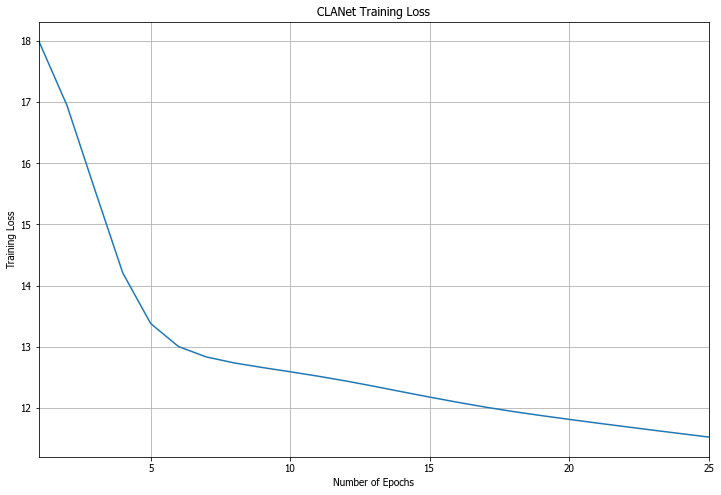

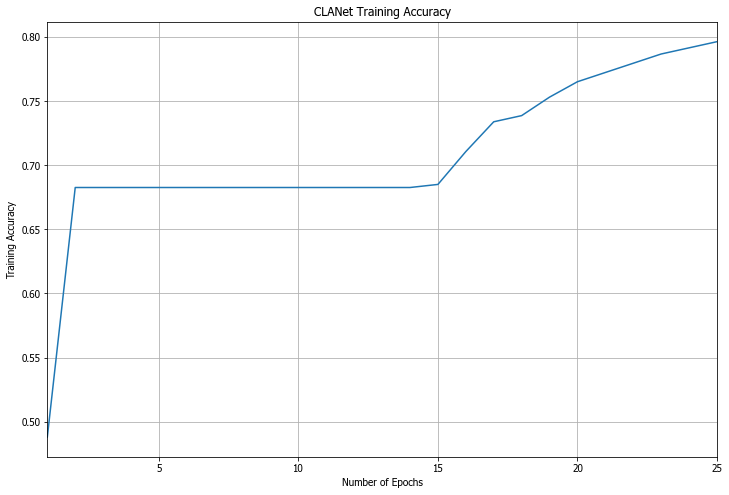

In [147]:
x = [i for i in range(1, num_epochs+1)]

plt.figure(figsize=(12, 8))
plt.plot(x, loss_arr)
plt.xlabel('Number of Epochs')
plt.ylabel('Training Loss')
plt.title('CLANet Training Loss')
plt.xlim([1, num_epochs])
plt.grid(True)

plt.figure(figsize=(12, 8))
plt.plot(x, acc_arr)
plt.xlabel('Number of Epochs')
plt.ylabel('Training Accuracy')
plt.title('CLANet Training Accuracy')
plt.xlim([1, num_epochs])
plt.grid(True)

## Test Model on Testing Set

In [148]:
model.eval()    # test model

for samples, target in test_loader:
    opt.zero_grad()
    output = model(samples)
    loss = criterion(output, target.squeeze(1).long())

    _, pred = torch.max(output, 1)
    
acc = torch.sum(pred == target.squeeze(1).long()).float() / len(target)
conf_matrix = confusion_matrix(target.numpy(), pred.numpy(), labels=[0, 1])

print('\nTest Accuracy: {:0.4f}'.format(acc))
print('Confusion Matrix:')
print(pd.DataFrame(conf_matrix))
print('\n\n')


Test Accuracy: 0.7255
Confusion Matrix:
    0   1
0  58   3
1  25  16





## Test Model on Holdout Set

In [ ]:
model.eval()    # test model

for samples, target in hold_loader:
    opt.zero_grad()
    output = model(samples)
    loss = criterion(output, target.squeeze(1).long())

    _, pred = torch.max(output, 1)
    
acc = torch.sum(pred == target.squeeze(1).long()).float() / len(target)
conf_matrix = confusion_matrix(target.numpy(), pred.numpy(), labels=[0, 1])

print('\nHoldout Accuracy: {:0.4f}'.format(acc))
print('Confusion Matrix:')
print(pd.DataFrame(conf_matrix))
print('\n\n')